In [29]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import datetime
import glob
import os

In [30]:
cinTest = pd.read_csv('assets/Cincy Crash Data.csv')
cinTest.head()

/var/folders/6f/pzb1mp0j39b1gqfhfdyf0qr80000gn/T/ipykernel_1873/4035067655.py:1: DtypeWarning: Columns (27) have mixed types. Specify dtype option on import or set low_memory=False.
  cinTest = pd.read_csv('assets/Cincy Crash Data.csv')


,ADDRESS_X,LATITUDE_X,LONGITUDE_X,AGE,COMMUNITY_COUNCIL_NEIGHBORHOOD,CPD_NEIGHBORHOOD,SNA_NEIGHBORHOOD,CRASHDATE,CRASHLOCATION,CRASHSEVERITY,...,MANNEROFCRASH,ROADCONDITIONSPRIMARY,ROADCONTOUR,ROADSURFACE,ROADCLASS,ROADCLASSDESC,UNITTYPE,TYPEOFPERSON,WEATHER,ZIP
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7/10/22 0:02,NaN,3 - MINOR INJURY SUSPECTED,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,39XX VINE ST,39.159791,-84.504421,NaN,NORTH AVONDALE,NORTH AVONDALE,AVONDALE,7/9/22 22:21,NaN,5 - PROPERTY DAMAGE ONLY,...,"7 - SIDESWIPE, SAME DIRECTION",01 - DRY,1 - STRAIGHT LEVEL,"2 - BLACKTOP, BITUMINOUS, ASPHALT",NaN,NaN,NaN,NaN,1 - CLEAR,45217
2,XX E 13TH ST,39.109675,-84.517324,37.0,OTR,OVER-THE-RHINE,OVER-THE-RHINE,7/9/22 21:18,NaN,5 - PROPERTY DAMAGE ONLY,...,1 - NOT COLLISION BETWEEN TWO MOTOR VEHICLES I...,01 - DRY,1 - STRAIGHT LEVEL,1 - CONCRETE,NaN,NaN,01 - PASSENGER CAR,D - DRIVER,1 - CLEAR,45202
3,XX E 13TH ST,39.109915,-84.516584,29.0,OTR,OVER-THE-RHINE,OVER-THE-RHINE,7/9/22 21:18,NaN,5 - PROPERTY DAMAGE ONLY,...,1 - NOT COLLISION BETWEEN TWO MOTOR VEHICLES I...,01 - DRY,1 - STRAIGHT LEVEL,1 - CONCRETE,NaN,NaN,23 - PEDESTRIAN/SKATER,P - PEDESTRIAN,1 - CLEAR,45202
4,15XX CENTRAL PY,39.111700,-84.521490,34.0,WEST END,WEST END,WEST END,7/9/22 21:09,NaN,5 - PROPERTY DAMAGE ONLY,...,2 - REAR-END,01 - DRY,2 - STRAIGHT GRADE,1 - CONCRETE,2.0,Major Arterial Roads,01 - PASSENGER CAR,D - DRIVER,1 - CLEAR,45214


In [31]:
cinMain = cinTest.filter(["AGE", "CRASHDATE", "INJURIES", "TYPEOFPERSON"], axis=1)
cinMain.head()

,AGE,CRASHDATE,INJURIES,TYPEOFPERSON
0,NaN,7/10/22 0:02,NaN,NaN
1,NaN,7/9/22 22:21,NaN,NaN
2,37.0,7/9/22 21:18,5 - NO APPARENTY INJURY,D - DRIVER
3,29.0,7/9/22 21:18,5 - NO APPARENTY INJURY,P - PEDESTRIAN
4,34.0,7/9/22 21:09,5 - NO APPARENTY INJURY,D - DRIVER


In [32]:
cinMain.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 95178 entries, 0 to 95177
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   AGE           81629 non-null  float64
 1   CRASHDATE     95178 non-null  object 
 2   INJURIES      95085 non-null  object 
 3   TYPEOFPERSON  95090 non-null  object 
dtypes: float64(1), object(3)
memory usage: 2.9+ MB


In [33]:
# float64 is a silly dtype for an Age column, but Age isn't always known, so this produces an error for blank entries
#
# cinMain["AGE"] = cinMain["AGE"].astype('int64')

cinMain["CRASHDATE"] = pd.to_datetime(cinMain["CRASHDATE"]).dt.date
cinMain.head()

,AGE,CRASHDATE,INJURIES,TYPEOFPERSON
0,NaN,2022-07-10,NaN,NaN
1,NaN,2022-07-09,NaN,NaN
2,37.0,2022-07-09,5 - NO APPARENTY INJURY,D - DRIVER
3,29.0,2022-07-09,5 - NO APPARENTY INJURY,P - PEDESTRIAN
4,34.0,2022-07-09,5 - NO APPARENTY INJURY,D - DRIVER


In [34]:
# Create a new Pandas series with entries for the total number of crashes per day.

# This is good, but a different data format which doesn't have an obvious way to access the computed values.

cinCrashes = cinMain.groupby(["CRASHDATE"]).size()
cinCrashes.head()

CRASHDATE
2019-07-09     90
2019-07-10    112
2019-07-11    100
2019-07-12     91
2019-07-13    105
dtype: int64

In [35]:
cinCrashes.info()

<class 'pandas.core.series.Series'>
Index: 1098 entries, 2019-07-09 to 2022-07-10
Series name: None
Non-Null Count  Dtype
--------------  -----
1098 non-null   int64
dtypes: int64(1)
memory usage: 17.2+ KB


<AxesSubplot:xlabel='CRASHDATE'>

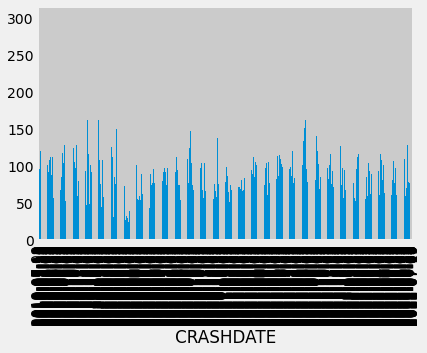

In [36]:
cinCrashes.plot(kind='bar')

This gives us a rough bar chart of crashes per day, but the x-axis is a mess.

(0.0, 325.0)

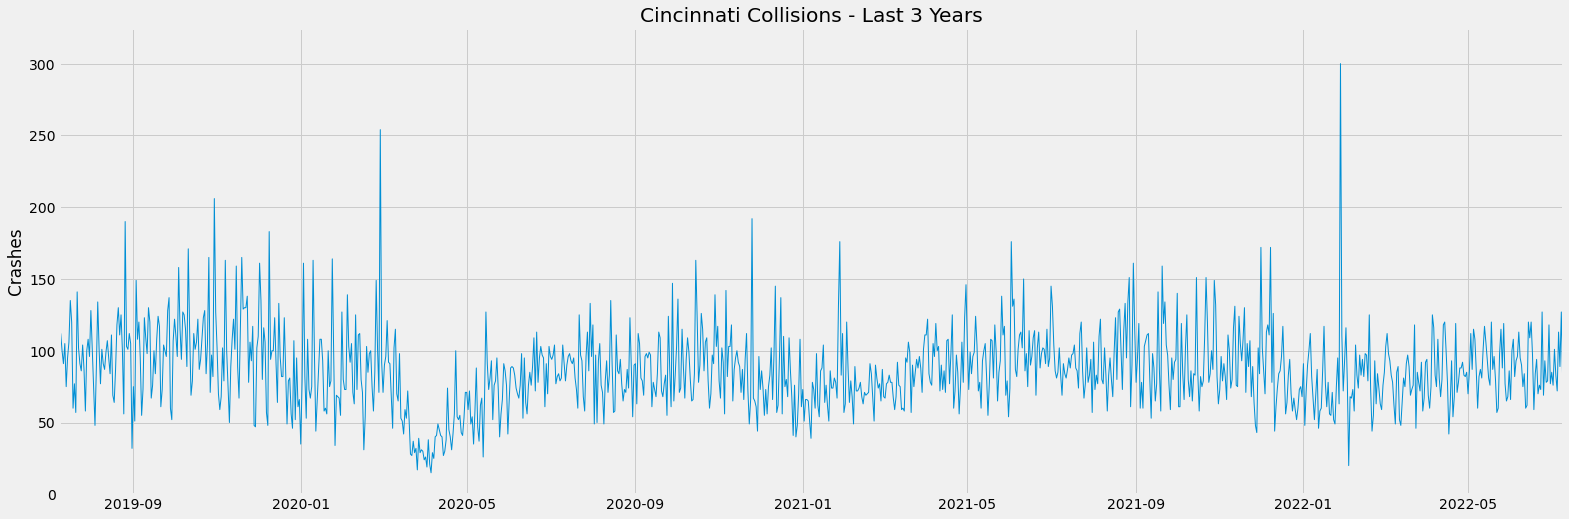

In [37]:
plt.style.use('fivethirtyeight')
plt.figure(figsize = (24, 8))
plt.plot(cinCrashes.index, cinCrashes.values, linewidth = 1)
# plt.xlabel('Date')
plt.ylabel('Crashes')
plt.title('Cincinnati Collisions - Last 3 Years')
plt.xlim(pd.Timestamp('2019-07-09'), pd.Timestamp('2022-07-09'))
plt.ylim(0, 325)

In [38]:
# Convert series to dataframe for access to rolling mean methods

# cinCrashes.to_frame()
# cinCrashes.columns = ["CRASHDATE", "TOTAL"]
# cinCrashes.head()

# Add a new column showing the rolling mean

cinDF = pd.DataFrame(cinCrashes)
cinDF['rolling'] = cinDF.rolling(7).mean()
cinDF.columns = ["total", "rolling"]
display(cinDF)

,total,rolling
CRASHDATE,,
2019-07-09,90,NaN
2019-07-10,112,NaN
2019-07-11,100,NaN
2019-07-12,91,NaN
2019-07-13,105,NaN
...,...,...
2022-07-06,113,86.714286
2022-07-07,89,88.428571
2022-07-08,127,94.428571


(0.0, 300.0)

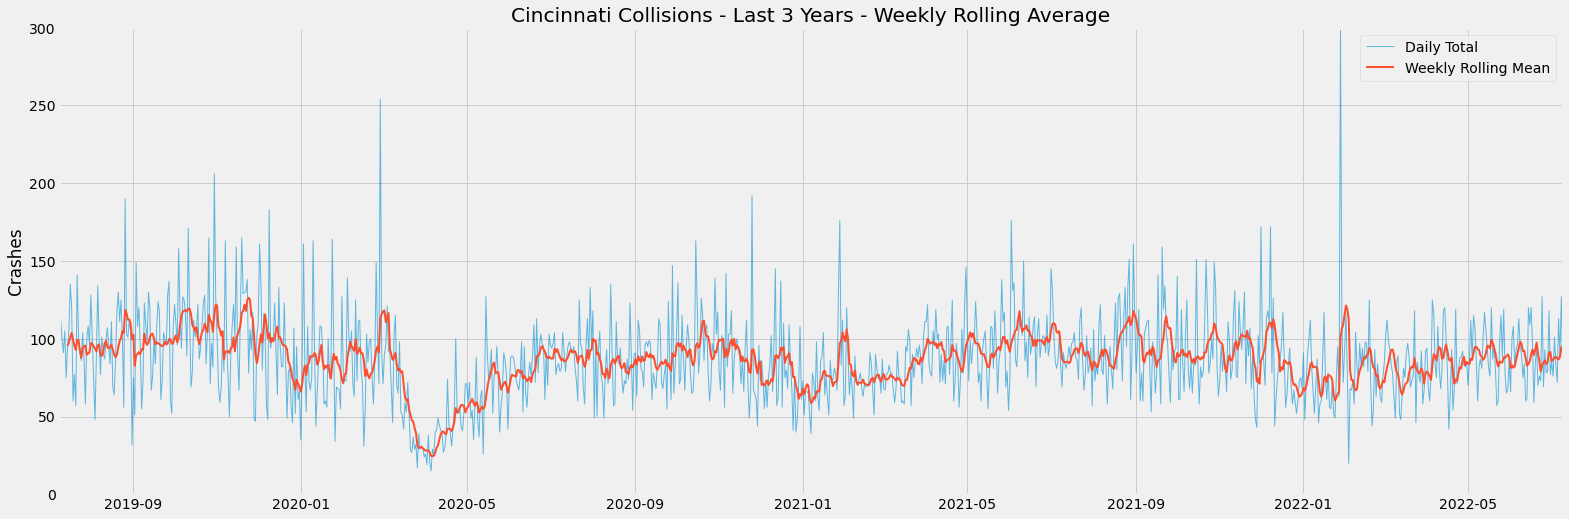

In [39]:
plt.style.use('fivethirtyeight')
plt.figure(figsize = (24, 8))
plt.plot(cinCrashes.index, cinCrashes.values, linewidth=1, alpha=0.6, label='Daily Total')
plt.plot(cinCrashes.index, cinDF["rolling"], linewidth=2, label='Weekly Rolling Mean')
# plt.xlabel('Date')
plt.ylabel('Crashes')
plt.title('Cincinnati Collisions - Last 3 Years - Weekly Rolling Average')
plt.legend()
plt.xlim(pd.Timestamp('2019-07-09'), pd.Timestamp('2022-07-09'))
plt.ylim(0, 300)
# plt(cinCrashes.index, cinDF["rolling"])

In [40]:
# Now it's time for the Louisville data. I had to pull it in 2-month chunks for the same 3-year period thanks to Kentucky's ancient website, so we need to concatenate 18 CSV files.

louTest = os.path.join("./assets", "louCrash*.csv")
louList = glob.glob(louTest)
louRaw = pd.concat(map(pd.read_csv, louList), ignore_index=True)
louRaw.head()

,IncidentID,AgencyORI,AgencyName,IncidentStatusDesc,County,RdwyNumber,Street,RoadwayName,StreetSfx,StreetDir,...,MannerofCollision,RdwyCharacter,LightCondition,RampFromRdwyId,RampToRdwyId,AcceptedDate,IsSecondaryCollision,OwnerBadge,IncidentStatus,Unnamed: 38
0,29797749,0568000,LOUISVILLE METRO POLICE DEPT,Accepted,JEFFERSON,NaN,NaN,CENTRAL,AVE,NaN,...,REAR END,STRAIGHT & LEVEL,DAWN,NaN,NaN,3/10/2022 8:08:38 AM,False,5379,Accepted,NaN
1,29797750,0568000,LOUISVILLE METRO POLICE DEPT,Accepted,JEFFERSON,US0031W,10500 BLK,DIXIE,HWY,NaN,...,REAR END,STRAIGHT & LEVEL,DAYLIGHT,NaN,NaN,3/10/2022 8:08:45 AM,False,2311,Accepted,NaN
2,29797757,0568000,LOUISVILLE METRO POLICE DEPT,Accepted,JEFFERSON,NaN,NaN,DUMESNIL,ST,NaN,...,ANGLE,STRAIGHT & LEVEL,DAYLIGHT,NaN,NaN,3/10/2022 8:09:17 AM,False,5412,Accepted,NaN
3,29797758,0568000,LOUISVILLE METRO POLICE DEPT,Accepted,JEFFERSON,NaN,1729,HILL,ST,W,...,ANGLE,STRAIGHT & LEVEL,DAYLIGHT,NaN,NaN,3/10/2022 8:09:21 AM,False,5412,Accepted,NaN
4,29797759,0568000,LOUISVILLE METRO POLICE DEPT,Accepted,JEFFERSON,NaN,NaN,CHEROKEE,RD,NaN,...,REAR END,CURVE & LEVEL,DAYLIGHT,NaN,NaN,3/10/2022 8:09:25 AM,False,5006,Accepted,NaN


In [41]:
# Perfect. Now we can use the same techniques as before with some adjustments for different data.

louMain = louRaw.filter(["NumberInjured", "NumberKilled", "DirAnalysisCode", "CollisionDate"], axis=1)
louMain.head()

,NumberInjured,NumberKilled,DirAnalysisCode,CollisionDate
0,0,0,OTHER INTERSECTION COLLISIONS,3/9/2022 12:00:00 AM
1,0,0,REAR END IN TRAFFIC LANES BOTH VEHICLES MOVING,3/9/2022 12:00:00 AM
2,4,0,ANGLE COLLISION - OTHER,3/9/2022 12:00:00 AM
3,1,0,1 VEHICLE ENTERING/LEAVING ENTRANCE,3/9/2022 12:00:00 AM
4,0,0,OTHER INTERSECTION COLLISIONS,3/9/2022 12:00:00 AM


In [44]:
louMain["CollisionDate"] = pd.to_datetime(louMain["CollisionDate"]).dt.date
louCrashes = louMain.groupby(["CollisionDate"]).size()
louCrashes.head()

CollisionDate
2019-07-09    73
2019-07-10    80
2019-07-11    70
2019-07-12    92
2019-07-13    59
dtype: int64

(0.0, 175.0)

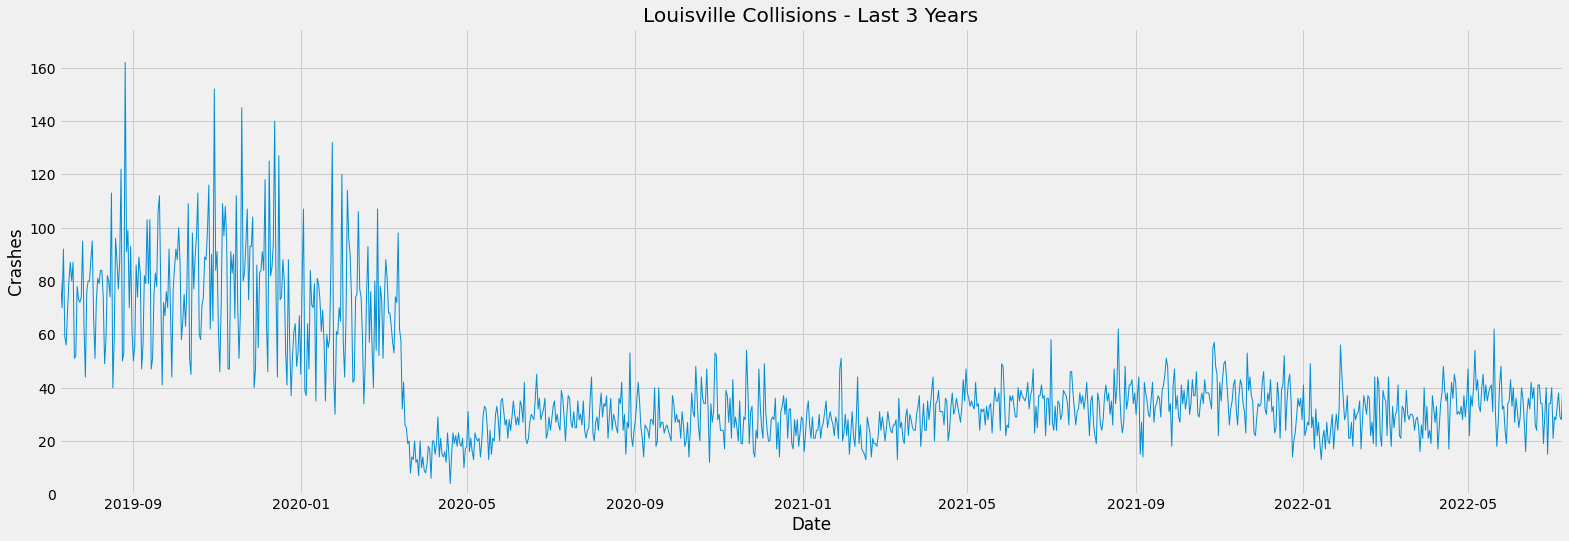

In [49]:
plt.style.use('fivethirtyeight')
plt.figure(figsize = (24, 8))
plt.plot(louCrashes.index, louCrashes.values, linewidth = 1)
plt.xlabel('Date')
plt.ylabel('Crashes')
plt.title('Louisville Collisions - Last 3 Years')
plt.xlim(pd.Timestamp('2019-07-09'), pd.Timestamp('2022-07-09'))
plt.ylim(0, 175)

(0.0, 175.0)

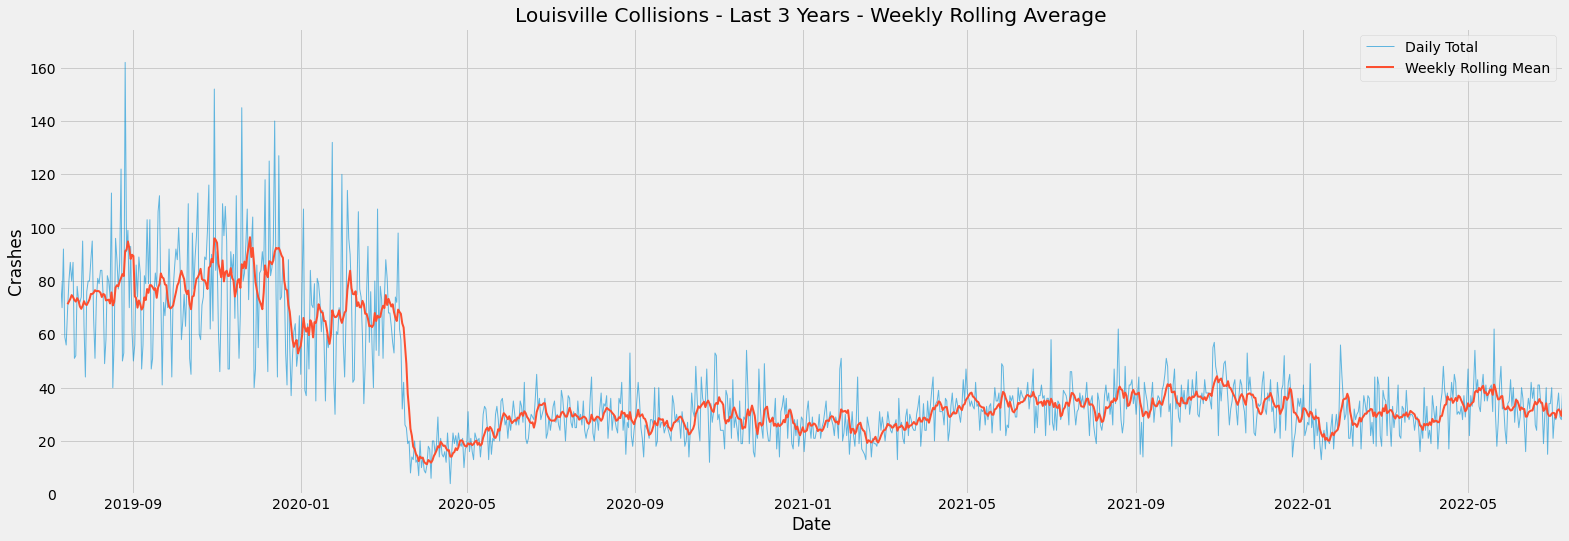

In [51]:
louDF = pd.DataFrame(louCrashes)
louDF['rolling'] = louDF.rolling(7).mean()
louDF.columns = ["total", "rolling"]

plt.style.use('fivethirtyeight')
plt.figure(figsize = (24, 8))
plt.plot(louCrashes.index, louCrashes.values, linewidth=1, alpha=0.6, label='Daily Total')
plt.plot(louCrashes.index, louDF["rolling"], linewidth=2, label='Weekly Rolling Mean')
plt.xlabel('Date')
plt.ylabel('Crashes')
plt.title('Louisville Collisions - Last 3 Years - Weekly Rolling Average')
plt.legend()
plt.xlim(pd.Timestamp('2019-07-09'), pd.Timestamp('2022-07-09'))
plt.ylim(0, 175)